# 1 TRAINING MNIST WITH K-NEAREST-NEIGHBOR
Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

In [12]:
from sklearn.datasets import fetch_openml


mnist = fetch_openml('mnist_784', as_frame=False)
print(mnist)

{'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64), 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object), 'frame': None, 'categories': {'class': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}, 'feature_names': ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55'

In [25]:
X, y = mnist.data, mnist.target
print(X.shape, y.shape)

# Split into test and training set
# x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
## >> more professional way to secure the data balance
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train, y_test = y_train.astype('int'), y_test.astype('int')
print(X_train.shape, y_train.shape)

(70000, 784) (70000,)
(56000, 784) (56000,)


In [26]:
# K-nearest neighbors classifier
# Create Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# K nearest neighbour uses euclidian so you should standardize the data beforehand
# Ziehe mittelwert ab und teile durch standardabweichung
clf = Pipeline(steps=
               [('scaler', StandardScaler()),
                ("knn", KNeighborsClassifier(n_neighbors=10))
                ])


In [29]:
### GRID SEARCH
# define hyperparameter for GridSearch
from sklearn.model_selection import GridSearchCV
# optimize hyperparameter using Grid
# which k is the best and should the distance matter or not
param_grid = {
    'knn__n_neighbors': [2,4,6,8,10],
    'knn__weights': ['uniform', 'distance']
}
# do grid search
## grid search below takes a long time so we are gonna make it shorter
grid_search = GridSearchCV(clf, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [30]:
# less data takes less time to run
X_train_small = X_train[:10000]
y_train_small = y_train[:10000]

grid_search = GridSearchCV(clf, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_small, y_train_small)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsClassifier(n_neighbors=10))]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [2, 4, 6, 8, 10],
                         'knn__weights': ['uniform', 'distance']},
             verbose=2)

In [31]:
# Now we look at the grid search results

print('Beste Parameter:', grid_search.best_params_)

Beste Parameter: {'knn__n_neighbors': 4, 'knn__weights': 'distance'}


In [34]:
# Lets evaluate these
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

# Show results in a table
import pandas as pd

results = pd.DataFrame(grid_search.cv_results_)
results = results[["param_knn__n_neighbors", "param_knn__weights", "mean_test_score"]]
print(results.sort_values(by="mean_test_score", ascending=False))

Test Accuracy: 0.9181
   param_knn__n_neighbors param_knn__weights  mean_test_score
3                       4           distance           0.9029
5                       6           distance           0.9020
7                       8           distance           0.8997
9                      10           distance           0.8968
6                       8            uniform           0.8956
1                       2           distance           0.8951
4                       6            uniform           0.8945
8                      10            uniform           0.8935
2                       4            uniform           0.8935
0                       2            uniform           0.8786


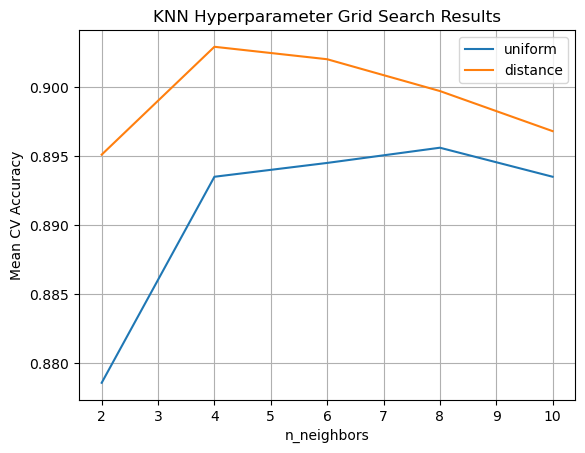

In [35]:
import matplotlib.pyplot as plt

for weight in ['uniform', 'distance']:
    subset = results[results['param_knn__weights'] == weight]
    plt.plot(subset['param_knn__n_neighbors'], subset['mean_test_score'], label=weight)

plt.xlabel('n_neighbors')
plt.ylabel('Mean CV Accuracy')
plt.legend()
plt.title('KNN Hyperparameter Grid Search Results')
plt.grid(True)
plt.show()

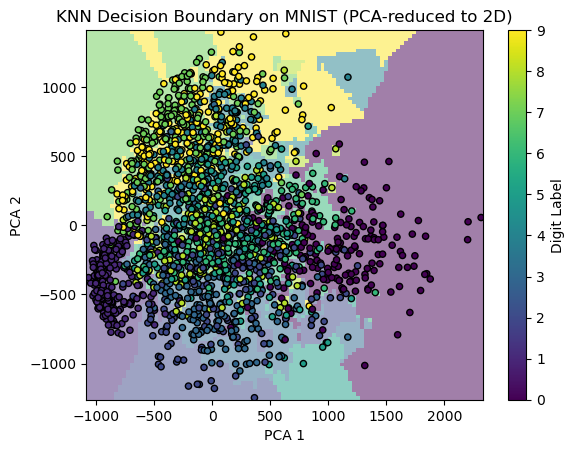

In [36]:
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt

# Schritt 1: PCA auf 2D
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train[:2000])  # Weniger Daten für Geschwindigkeit
y_train_pca = y_train[:2000]

# Schritt 2: Neue Pipeline mit PCA + KNN (ohne StandardScaler, da PCA schon skaliert)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

clf_pca = make_pipeline(
    KNeighborsClassifier(n_neighbors=4, weights="distance")
)
clf_pca.fit(X_train_pca, y_train_pca)

# Schritt 3: Plot
disp = DecisionBoundaryDisplay.from_estimator(
    clf_pca,
    X_train_pca,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
    alpha=0.5
)

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_pca, edgecolors="k", s=20)
plt.title("KNN Decision Boundary on MNIST (PCA-reduced to 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Digit Label")
plt.show()


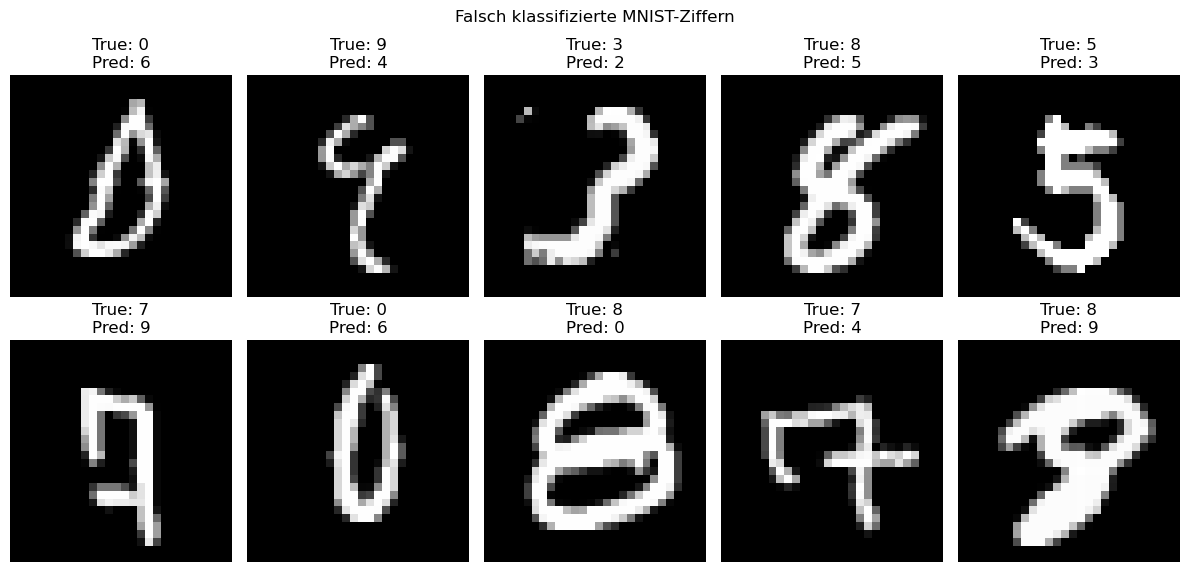

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Vorhersagen holen
y_pred = grid_search.predict(X_test)

# Falsch klassifizierte Indizes
misclassified = np.where(y_pred != y_test)[0]

# Einige falsche vorhersagen anzeigen
plt.figure(figsize=(12, 6))
for i, idx in enumerate(misclassified[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap="gray")
    plt.title(f"True: {y_test[idx]}\nPred: {y_pred[idx]}")
    plt.axis("off")
plt.suptitle("Falsch klassifizierte MNIST-Ziffern")
plt.tight_layout()
plt.show()


In [46]:
# Beispiel: Du hast gefunden, dass k=4 und weights="distance" optimal war
final_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=3, weights='distance'))
])
final_knn.fit(X_train, y_train)  # Jetzt auf alle 56.000 Trainingsdaten

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=3, weights='distance'))])

In [47]:
y_pred = final_knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9477857142857142


              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1343
           1       0.96      0.99      0.98      1600
           2       0.95      0.94      0.95      1380
           3       0.94      0.95      0.94      1433
           4       0.95      0.93      0.94      1295
           5       0.94      0.94      0.94      1273
           6       0.97      0.98      0.97      1396
           7       0.94      0.93      0.93      1503
           8       0.96      0.91      0.93      1357
           9       0.90      0.93      0.91      1420

    accuracy                           0.95     14000
   macro avg       0.95      0.95      0.95     14000
weighted avg       0.95      0.95      0.95     14000



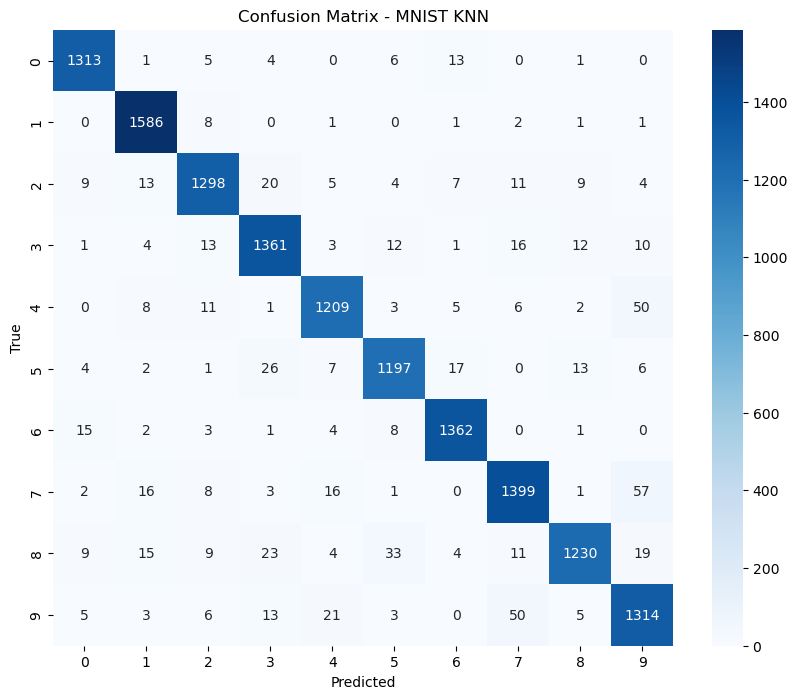

In [48]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MNIST KNN")
plt.show()